<a href="https://colab.research.google.com/github/gitgeek28/Building-Cross-Timeframe-Trading-Architectures/blob/main/Nifty_50_daily_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtester Usage guide

Step 1: If you need any indicator not already included in the "Defining functions for technical indicators section then add a function which calculates that accordingly

Step 2: Modify the Preprocessing function to include the indicators that you need

Step 3: In the main strategy section, modify the Strategy function according to your strategy. You have to add a column named "Position" to the dataframe which is 1 if you're in a long trade and -1 if you're in a short trade. Signal generation is taken care of in post processing

Step 4: In main run section, import data from a csv or yfinance using fetch_data(ticker) for yfin and create_dataset(csv_path) for importing from a CSV. Then in preprocess function call set the start and end date for backtest.

# Importing modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
# import yfinance as yf
from collections import defaultdict
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore')

# Importing data

You can use **create_dataset(path)** to import data from a csv file or use **fetch_data(ticker, interval)** to fetch data from yfinance for given ticker with given interval candles

## Using yfinance

In [ ]:

def fetch_data_from_csv(file_path):

    data = pd.read_csv(file_path)

    # Standardize column names if needed
    data.rename(columns = {
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume',
        'date': 'datetime'  # or adjust if it's called 'Timestamp'
    }, inplace=True)

    # Make sure datetime column is actual datetime
    data['datetime'] = pd.to_datetime(data['datetime'])

    # Reset index if not already
    data.reset_index(drop=True, inplace=True)

    return data





## Using CSV

In [ ]:
def create_dataset(path):
  df = pd.read_csv(path)
  return df

# Defining functions for technical indicators

Included technical indicators in this file: <br>
RSI<br>
SMA<br>
EMA<br>
HeikenAshi<br>
ATR<br>
ADX<br>
MACD<br>
<br>
Refer to the comment above the definition of the function to check the format you get the indicator values in

## RSI

In [ ]:
#calculate RSI and add a column with name "RSI_x" where x is the lookback period
def RSI(df, lookback=14):
    close = df['close']
    ret = close.diff().dropna()
    up = []
    down = []
    for i in range(len(ret)):
        if ret.iloc[i] < 0:
            up.append(0)
            down.append(ret.iloc[i])
        else:
            up.append(ret.iloc[i])
            down.append(0)
    up_series = pd.Series(up, index=ret.index)
    down_series = pd.Series(down, index=ret.index).abs()
    up_ewm = up_series.ewm(com=lookback - 1, adjust=False).mean()
    down_ewm = down_series.ewm(com=lookback - 1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    df["RSI_" + str(lookback)] = rsi.reindex(df.index)

## Moving averages

In [ ]:
# calculate EMA and add a column with name "EMA_x" where x is the lookback period
def EMA(df, n):
    df['EMA_'+str(n)] = df['close'].ewm(span=n, min_periods=n).mean()

# calculate SMA and add a column with name "EMA_x" where x is the lookback period
def SMA(df, n):
    df['SMA_'+str(n)] = df['close'].rolling(window=n).mean()

## Heikenashi

In [ ]:
# calculate HA candles and add columns with name "HA_Close" "HA_Open" "HA_High" "HA_Low"
def HA(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['HA_Open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
    df['HA_High'] = df[['high', 'low', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['high', 'low', 'HA_Open', 'HA_Close']].min(axis=1)

## ATR


In [ ]:
# calculate ATR and add a column with name "ATR"
def ATR(df, n=14):
    df['TR'] = np.maximum(df['high'] - df['low'],
                          np.maximum(abs(df['high'] - df['close'].shift(1)),
                                     abs(df['low'] - df['close'].shift(1)))
                         )
    df[f'ATR'] = df['TR'].ewm(span=n, min_periods=n).mean()
    df.drop('TR', axis=1, inplace=True)

## ADX


In [ ]:
#calculate ADX
def ADX(df,lookback=14):
    high = df['high']
    low = df['low']
    close = df['close']
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df[f"ADX_{lookback}"] = adx_smooth

## MACD

In [ ]:
# calculate MACD and add 2 columns with name "MACD" and "Signal Line"
def MACD(df, n_fast=12, n_slow=26):
    EMA(df, n_fast)
    EMA(df, n_slow)
    df['MACD'] = df['EMA_' + str(n_fast)] - df['EMA_' + str(n_slow)]
    df['Signal Line'] = df['MACD'].ewm(span=9, min_periods=9).mean()

## SUPERTREND

In [ ]:
import pandas as pd

def calculate_supertrend(df, period=14, atr_multiplier=3):
    # Calculate ATR
    df['High-Low'] = df['high'] - df['low']
    df['High-Close'] = abs(df['high'] - df['close'].shift(1))
    df['Low-Close'] = abs(df['low'] - df['close'].shift(1))
    tr = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    atr = tr.rolling(window=period).mean()

    # Calculate Supertrend
    df['Upperband'] = ((df['high'] + df['low']) / 2) + (atr_multiplier * atr)
    df['Lowerband'] = ((df['high'] + df['low']) / 2) - (atr_multiplier * atr)
    df['supertrend'] = 0.0

    # Vectorized logic for supertrend calculation
    for i in range(1, len(df)):
        if df.at[i, 'close'] > df.at[i-1, 'Upperband']:
            df.at[i, 'supertrend'] = df.at[i, 'Lowerband']
        elif df.at[i, 'close'] < df.at[i-1, 'Lowerband']:
            df.at[i, 'supertrend'] = df.at[i, 'Upperband']
        else:
            df.at[i, 'supertrend'] = df.at[i-1, 'supertrend']
            if df.at[i-1, 'supertrend'] == df.at[i-1, 'Upperband'] and df.at[i, 'close'] <= df.at[i, 'Upperband']:
                df.at[i, 'supertrend'] = df.at[i, 'Upperband']
            if df.at[i-1, 'supertrend'] == df.at[i-1, 'Lowerband'] and df.at[i, 'close'] >= df.at[i, 'Lowerband']:
                df.at[i, 'supertrend'] = df.at[i, 'Lowerband']

    # Cleanup
    df.drop(['Upperband', 'Lowerband', 'High-Low', 'High-Close', 'Low-Close'], axis=1, inplace=True)
    return df['supertrend']


In [ ]:
import pandas as pd

def donchian(df, period):
    """Calculate the Donchian channel as the average of the highest high and lowest low over a given period."""
    return (df['high'].rolling(window=period).max() + df['low'].rolling(window=period).min()) / 2

def calculate_tenkan_sen(df, tenkan_period=9):
    """Calculate the Tenkan Sen (conversion line)."""
    return donchian(df, tenkan_period)

def calculate_kijun_sen(df, kijun_period=24):
    """Calculate the Kijun Sen (base line)."""
    return donchian(df, kijun_period)

def calculate_senkou_span_a(tenkan_sen, kijun_sen):
    """Calculate the Senkou Span A as the average of Tenkan Sen and Kijun Sen."""
    return (tenkan_sen + kijun_sen) / 2

def calculate_senkou_span_b(df, senkou_span_b_period=51):
    """Calculate the Senkou Span B as the average of the highest high and lowest low over a given period."""
    return donchian(df, senkou_span_b_period)

def calculate_chikou_span(df, displacement=24):
    """Calculate the Chikou Span (lagging line) as the close price displaced back by a given period."""
    return df['close'].shift(-displacement)

def ichimoku(df, tenkan_period=9, kijun_period=24, senkou_span_b_period=51, displacement=24):
    """Calculate all Ichimoku indicator lines and return them as a DataFrame."""

    df['Tenkan_Sen'] = calculate_tenkan_sen(df, tenkan_period)
    df['Kijun_Sen'] = calculate_kijun_sen(df, kijun_period)
    df['Senkou_Span_A'] = calculate_senkou_span_a(df['Tenkan_Sen'], df['Kijun_Sen']).shift(displacement)
    df['Senkou_Span_B'] = calculate_senkou_span_b(df, senkou_span_b_period).shift(displacement)
    df['Chikou_Span'] = calculate_chikou_span(df, displacement)

    # Highlight the cloud upper and lower bounds
    df['Senkou_Span_H'] = df[['Senkou_Span_A', 'Senkou_Span_B']].max(axis=1)
    df['Senkou_Span_L'] = df[['Senkou_Span_A', 'Senkou_Span_B']].min(axis=1)

    return df[['Tenkan_Sen', 'Kijun_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'Senkou_Span_H', 'Senkou_Span_L']]




# Preprocessing on the data

Calculate all the indicators you need and select the interval you want to bactest on using this function

In [ ]:
def preprocess(df, start, end):
    # Calculate indicators first
    EMA(df, 40)
    EMA(df, 7)
    HA(df)
    ATR(df)
    ADX(df, 15)
    df['supertrend_7'] = calculate_supertrend(df,7,2)
    df['supertrend_20'] = calculate_supertrend(df,20,6)
    SMA(df,200)
    SMA(df,20)
    SMA(df,50)
    EMA(df, 9)
    EMA(df, 21)
    ichimoku(df)

    # Convert datetime if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Filter dates (ensure proper datetime comparison)
    mask = (df['datetime'] >= pd.to_datetime(start)) & (df['datetime'] <= pd.to_datetime(end))
    df = df.loc[mask].copy()
    df.reset_index(drop=True, inplace=True)

    # Initialize columns
    df['Position'] = 0
    df['signals'] = 0
    df['stoploss'] = 0

    return df

# Postprocessing the data

Assumptions: You feed a dataframe in the function which has a column named "Position" which is 1 if you're in a long trade and "-1" if you're in a short trade. The function handles the signal generation

In [ ]:
def gen_signals(df):
    """
    Generates clean trade signals from position changes
    Returns DataFrame with 'signals' column:
    1 = Enter Long, -1 = Enter Short
    2 = Exit Long, -2 = Exit Short
    """
    df = df.copy()
    df['signals'] = 0

    for i in range(1, len(df)):
        prev_pos = df.at[i-1, 'Position']
        curr_pos = df.at[i, 'Position']

        # No position change
        if prev_pos == curr_pos:
            continue

        # Entering long
        if prev_pos == 0 and curr_pos == 1:
            df.at[i, 'signals'] = 1

        # Entering short
        elif prev_pos == 0 and curr_pos == -1:
            df.at[i, 'signals'] = -1

        # Exiting long
        elif prev_pos == 1 and curr_pos == 0:
            df.at[i, 'signals'] = 2

        # Exiting short
        elif prev_pos == -1 and curr_pos == 0:
            df.at[i, 'signals'] = -2

        # Long to Short reversal
        elif prev_pos == 1 and curr_pos == -1:
            df.at[i, 'signals'] = 2  # Exit long first
            df.at[i, 'signals'] = -1  # Then enter short

        # Short to Long reversal
        elif prev_pos == -1 and curr_pos == 1:
            df.at[i, 'signals'] = -2  # Exit short first
            df.at[i, 'signals'] = 1   # Then enter long

    return df

In [ ]:
def post_process(df, initial_capital=1500000, slippage=0.0001, risk_per_trade=0.01, atr_multiplier=0.1):
    """
    Realistic trade processing with proper position sizing and risk management
    Returns:
    - Processed DataFrame with trade details
    - Equity curve array
    - Performance metrics dictionary
    - Trade log list
    """
    if 'signals' not in df.columns:
        df = gen_signals(df)

    # Initialize tracking variables
    position = 0          # Current position (1=long, -1=short, 0=flat)
    entry_price = 0       # Price at which current position was entered
    trade_log = []        # List to store all trades
    equity_curve = [initial_capital]  # Portfolio value over time
    daily_returns = [0]   # Daily percentage returns
    drawdowns = [0]       # Drawdown percentages
    peak_equity = initial_capital
    current_cash = initial_capital
    position_size = 1     # Number of units held
    position_value = 0    # Current value of the position

    # Constants for Nifty/BankNifty -
    LOT_SIZES = {'NIFTY': 75, 'BANKNIFTY': 30}
    MARGIN_PERCENT = 0.20
    instrument = 'NIFTY'  # Assuming you are trading Nifty

    for i in range(1, len(df)):
        prev_equity = equity_curve[-1]
        current_price = df.at[i, 'close']
        current_atr = df.at[i, 'ATR']
        signal = df.at[i, 'signals']

        # Handle trade signals
        if signal != 0:
            # First exit any existing position
            if position != 0:
                # Calculate exit price with slippage
                exit_price = current_price * (1 - slippage if position == 1 else 1 + slippage)
                pnl = position_size * (exit_price - entry_price) * position

                # Update cash position
                current_cash += position_size * entry_price + pnl

                # Log the trade
                trade_log.append({
                    'entry_date': df.at[i-1, 'datetime'],
                    'exit_date': df.at[i, 'datetime'],
                    'type': 'long' if position == 1 else 'short',
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'return': pnl / (position_size * entry_price) if position_size * entry_price != 0 else 0,
                    'size': position_size
                })

                position = 0
                position_size = 0
                position_value = 0

            # Enter new position if signal exists and we have capital
            if signal in [1, -1] and current_cash > 0:
                position = 1 if signal == 1 else -1
                entry_price = current_price * (1 + slippage if position == 1 else 1 - slippage)

                # Calculate position size based on risk
                risk_amount = min(current_cash * risk_per_trade, current_cash * 0.1)  # Max 10% per trade
                dollar_risk_per_unit = current_atr * atr_multiplier
                position_size = risk_amount / dollar_risk_per_unit

                # Adjust for lot sizes - using assumed instrument
                position_size = (position_size // LOT_SIZES[instrument]) * LOT_SIZES[instrument]

                # Calculate margin required
                notional_value = position_size * entry_price
                margin_required = notional_value * MARGIN_PERCENT

                # Ensure we have enough capital
                if margin_required > current_cash:
                    position_size = (current_cash // (entry_price * MARGIN_PERCENT * LOT_SIZES[instrument])) * LOT_SIZES[instrument]

                if position_size > 0:
                    current_cash -= position_size * entry_price
                else:
                    position = 0  # Not enough capital to take position

        # Update position value
        if position != 0:
            position_value = position_size * (current_price - entry_price) * position

        # Calculate current equity
        current_equity = current_cash + (position_size * entry_price) + position_value
        equity_curve.append(current_equity)

        # Calculate daily return
        daily_return = (current_equity / prev_equity - 1) if prev_equity != 0 else 0
        daily_returns.append(daily_return)

        # Update drawdown
        peak_equity = max(peak_equity, current_equity)
        drawdown = (peak_equity - current_equity) / peak_equity if peak_equity != 0 else 0
        drawdowns.append(drawdown)

    # Calculate performance metrics
    daily_returns_series = pd.Series(daily_returns)
    positive_trades = [t for t in trade_log if t['pnl'] > 0]

    metrics = {
        'Initial Capital': initial_capital,
        'Final Equity': equity_curve[-1],
        'Total Return (%)': (equity_curve[-1] / initial_capital - 1) * 100,
        'CAGR (%)': (equity_curve[-1] / initial_capital) ** (252/len(df)) * 100 - 100 if len(df) > 252 else 0,
        'Sharpe Ratio': (daily_returns_series.mean() * 252) / (daily_returns_series.std() * np.sqrt(252)) if daily_returns_series.std() != 0 else 0,
        'Calmar Ratio': ((equity_curve[-1] / initial_capital) ** (252/len(df)) - 1) / max(drawdowns) if max(drawdowns) != 0 else 0,
        'Max Drawdown (%)': max(drawdowns) * 100,
        'Win Rate (%)': (len(positive_trades) / len(trade_log)) * 100 if trade_log else 0,
        'Profit Factor': sum(t['pnl'] for t in positive_trades) / abs(sum(t['pnl'] for t in trade_log if t['pnl'] < 0)) if trade_log and any(t['pnl'] < 0 for t in trade_log) else 0,
        'Number of Trades': len(trade_log),
        'Avg Winning Trade (%)': (sum(t['return'] for t in positive_trades)/len(positive_trades)) * 100 if positive_trades else 0,
        'Avg Losing Trade (%)': (sum(t['return'] for t in trade_log if t['pnl'] < 0)/len([t for t in trade_log if t['pnl'] < 0])) * 100 if any(t['pnl'] < 0 for t in trade_log) else 0,
        'Time in Market (%)': (sum(1 for p in df['Position'] if p != 0) / len(df)) * 100 if len(df) > 0 else 0  # Handle zero length DataFrame
    }

    return df, equity_curve, metrics, trade_log

# Main Strategy

In [ ]:
def Strategy(df):
    df['Position'] = 0

    # === MACD & Signal Line ===
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # === ATR for Supertrend ===
    df['H-L'] = df['high'] - df['low']
    df['H-C'] = abs(df['high'] - df['close'].shift())
    df['L-C'] = abs(df['low'] - df['close'].shift())
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=10).mean()

    # === Supertrend (10, 3) Calculation ===
    multiplier = 3
    hl2 = (df['high'] + df['low']) / 2
    df['UpperBand'] = hl2 + (multiplier * df['ATR'])
    df['LowerBand'] = hl2 - (multiplier * df['ATR'])
    df['Supertrend'] = np.nan
    direction = True  # Assume starting in uptrend

    for i in range(1, len(df)):
        if direction:
            if df['close'][i] > df['LowerBand'][i]:
                df['Supertrend'][i] = df['LowerBand'][i]
            else:
                direction = False
                df['Supertrend'][i] = df['UpperBand'][i]
        else:
            if df['close'][i] < df['UpperBand'][i]:
                df['Supertrend'][i] = df['UpperBand'][i]
            else:
                direction = True
                df['Supertrend'][i] = df['LowerBand'][i]

    # === Clean NaNs ===
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['MACD', 'Signal', 'Supertrend'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # === Strategy Logic with Combined Exit ===
    for i in range(1, len(df)):
        if df['MACD'][i-1] < df['Signal'][i-1] and df['MACD'][i] > df['Signal'][i]:
            df.loc[i, 'Position'] = 1  # Entry (long only)
        elif (df['MACD'][i-1] > df['Signal'][i-1] and df['MACD'][i] < df['Signal'][i]) or \
             (df['close'][i] < df['Supertrend'][i]):
            df.loc[i, 'Position'] = 0  # Exit on MACD cross down OR close < supertrend
        else:
            df.loc[i, 'Position'] = df.loc[i-1, 'Position']

    return df


# Main Run

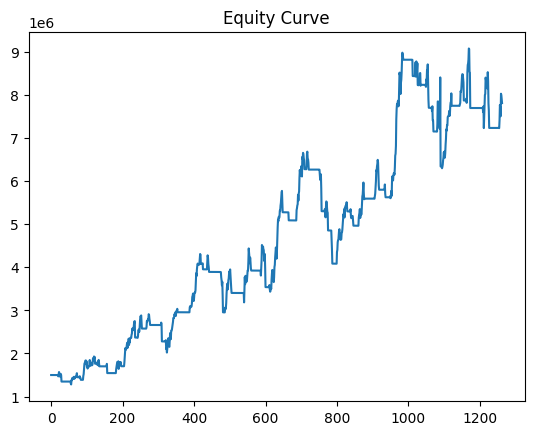

Initial Capital: 1500000
Final Equity: 7811485.40925001
Total Return (%): 420.7656939500007
CAGR (%): 38.99143081476123
Sharpe Ratio: 1.0372160480710189
Calmar Ratio: 1.0024120018445206
Max Drawdown (%): 38.89760970839713
Win Rate (%): 48.888888888888886
Profit Factor: 1.693808515072196
Number of Trades: 45
Avg Winning Trade (%): 3.9023188299516445
Avg Losing Trade (%): -1.5216474537233942
Time in Market (%): 47.50593824228028


In [ ]:
df = fetch_data_from_csv(r"resampled_nifty_50_daily.csv")
df = preprocess(df, '2020-01-01', '2025-03-31')



# After running your strategy
df = Strategy(df)  # Your strategy implementation
df = gen_signals(df)  # Generate signals
processed_df, equity_curve, metrics, trade_log = post_process(df, initial_capital=1500000)

# Plot equity curve
plt.plot(equity_curve)
plt.title('Equity Curve')
plt.show()
# After preprocessing, check your data
# print(df.isnull().sum())
# print(df.describe())


# Print metrics

for k, v in metrics.items():
    print(f"{k}: {v}")

In [ ]:
# df[df["datetime"] == "2020-01-31"]
df


,datetime,open,high,low,close,volume,EMA_40,EMA_7,HA_Close,HA_Open,...,stoploss,MACD,Signal,H-L,H-C,L-C,TR,UpperBand,LowerBand,Supertrend
0,2020-01-14,12333.10,12373.65,12309.35,12360.05,0,NaN,12247.221622,12344.0375,12313.150,...,0,18.169608,-2.011143,64.30,44.05,20.25,64.30,12711.160,11971.840,11971.840
1,2020-01-15,12349.40,12355.00,12279.05,12340.35,0,NaN,12271.530401,12330.9500,12346.575,...,0,26.758759,3.742838,75.95,5.05,81.00,81.00,12693.990,11940.060,11940.060
2,2020-01-16,12347.10,12389.00,12315.85,12354.05,0,NaN,12292.835158,12351.5000,12344.875,...,0,34.276086,9.849487,73.15,48.65,24.50,73.15,12721.320,11983.530,11983.530
3,2020-01-17,12328.40,12385.25,12322.25,12346.10,0,NaN,12306.475424,12345.5000,12350.575,...,0,39.140930,15.707776,63.00,31.20,31.80,63.00,12714.560,11992.940,11992.940
4,2020-01-20,12430.50,12430.50,12217.25,12230.75,0,NaN,12287.200630,12327.2500,12337.250,...,0,33.304658,19.227152,213.25,84.40,128.85,213.25,12674.305,11973.445,11973.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,2025-02-03,23319.35,23381.60,23222.00,23359.70,0,23571.606829,23319.932962,23320.6625,23511.950,...,0,-121.024498,-187.841224,159.60,113.70,273.30,273.30,24062.900,22540.700,22540.700
1259,2025-02-04,23509.90,23762.75,23423.15,23707.70,0,23578.245521,23416.874722,23600.8750,23339.525,...,0,-79.313798,-166.135739,339.60,403.05,63.45,403.05,24418.490,22767.410,22767.410
1260,2025-02-05,23801.75,23807.30,23680.45,23686.75,0,23583.538422,23484.343541,23744.0625,23608.800,...,0,-47.401839,-142.388959,126.85,99.60,27.25,126.85,24553.425,22934.325,22934.325
1261,2025-02-06,23761.95,23773.55,23556.25,23628.05,0,23585.709719,23520.270156,23679.9500,23744.250,...,0,-26.542020,-119.219571,217.30,86.80,130.50,217.30,24450.450,22879.350,22879.350
